In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging
import datetime
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)

c:\Users\noraky\anaconda3\envs\pypsa-earth-nora\lib\site-packages\pypsa\networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
n_simulations = 20
path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/monte_carlo_networks/network_'
#path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/csa_results_em/'
#path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/csa_results/'
#path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/solstorm_3_mc_networks/network_'
#path = '/mnt/beegfs/users/noraky/pypsa-earth/monte_carlo_networks/network_'
#networks = [pypsa.Network(path + str(i) + '.nc') for i in range(1,n_simulations+1)]
teal3 = '#527D77'
price_LL = 22000

In [16]:
# Helper functions

def get_snapshot_generation(network, first_date, second_date, carrier):
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(network, first_date, second_date):
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)
    return demand

def calculate_lost_load(network, first_date="2013-01-01", second_date="2013-12-31"):
    CCGT = get_snapshot_generation(network, first_date, second_date, 'CCGT')
    OCGT = get_snapshot_generation(network, first_date, second_date, 'OCGT')
    Oil = get_snapshot_generation(network, first_date, second_date, 'oil')
    Geothermal = get_snapshot_generation(network, first_date, second_date, 'geothermal')
    Hydro = get_snapshot_generation(network, first_date, second_date, 'ror') + get_snapshot_generation(network, first_date, second_date, 'hydro')
    Wind = get_snapshot_generation(network, first_date, second_date, 'onwind')
    Solar = get_snapshot_generation(network, first_date, second_date, 'solar')
    Biomass = get_snapshot_generation(network, first_date, second_date, 'biomass')
    Battery = get_snapshot_generation(network, first_date, second_date, 'battery')
    demand = get_snapshot_demand(network, first_date, second_date)

    nbattery = [(i*-1) if i < 0 else 0 for i in Battery]
    pbattery = [i if i > 0 else 0 for i in Battery]

    nbattery_9 = [float(n) / 0.9 for n in nbattery]
    pbattery_9 = [float(n) * 0.9 for n in pbattery]

    LL = (demand.values + nbattery_9) - (CCGT + OCGT + Oil + Wind + Solar + Biomass + Hydro + pbattery_9 + Geothermal)
    return LL

def load_matrices(iteration):
    df_lines = pd.read_csv(f'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/matrices/lines_matrix_{iteration}.csv')
    #df_lines = pd.read_csv(f'/mnt/beegfs/users/noraky/pypsa-earth/monte_carlo_networks/lines_matrix_{iteration}.csv')
    df_generators = pd.read_csv(f'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/matrices/generators_matrix_{iteration}.csv')
    #df_generators = pd.read_csv(f'/mnt/beegfs/users/noraky/pypsa-earth/monte_carlo_networks/generators_matrix_{iteration}.csv')
    df_storage_units = pd.read_csv(f'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/matrices/storage_units_matrix_{iteration}.csv')
    #df_storage_units = pd.read_csv(f'/mnt/beegfs/users/noraky/pypsa-earth/monte_carlo_networks/storage_units_matrix_{iteration}.csv')
    
    # Assuming the datetime column is named 'datetime' and is the first column
    datetime_column = df_generators['datetime']

    # Drop the datetime column for concatenation
    df_generators = df_generators.drop(columns=['datetime'])
    df_lines = df_lines.drop(columns=['datetime'])
    df_storage_units = df_storage_units.drop(columns=['datetime'])
    
    # Concatenate the dataframes horizontally
    states_df = pd.concat([df_lines, df_generators, df_storage_units], axis=1)
    
    # Reinsert the datetime column at the beginning
    states_df.insert(0, 'datetime', datetime_column)
    
    return states_df

def get_top_lost_load_hours(all_LL_values, top_n_hours=100):
    all_LL_df = pd.DataFrame(all_LL_values, columns=['Lost_Load', 'Simulation', 'Hour', 'Datetime'])
    top_hours_df = all_LL_df.nlargest(top_n_hours, 'Lost_Load').reset_index(drop=True)
    return top_hours_df

def analyze_top_hours(top_hours_df):
    results = []
    for idx, row in top_hours_df.iterrows():
        iteration = int(row['Simulation'])
        hour = int(row['Hour'])
        datetime_value = row['Datetime']
        lost_load = row['Lost_Load']
        rank = idx + 1  # One-based ranking

        # Load the state matrices for the specific iteration
        states_df = load_matrices(iteration)
        states_at_hour = states_df.iloc[hour, 1:]  # Skip datetime column
        failed_components = states_at_hour[states_at_hour == 0].index.tolist()
        results.append([rank, iteration, datetime_value, lost_load, failed_components])

    return results

def analyze_lost_loads(all_LL_values, state_matrices, n_simulations):
    component_caused_ll = defaultdict(list)
    multiple_components_caused_ll = defaultdict(list)
    yearly_component_lost_load = defaultdict(list)
    yearly_combination_lost_load = defaultdict(list)

    for iteration in range(101, n_simulations + 101):
        yearly_lost_load = defaultdict(float)
        yearly_combination_load = defaultdict(float)
        for ll, iter_num, hour, datetime_value in all_LL_values:
            if iter_num != iteration:
                continue
            if ll > 0:
                states_df = state_matrices[iteration]
                states_at_hour = states_df.iloc[hour, 1:]  # Skip datetime column
                failed_components = states_at_hour[states_at_hour == 0].index.tolist()

                if len(failed_components) == 1:
                    component = failed_components[0]
                    component_caused_ll[component].append(ll)
                    yearly_lost_load[component] += ll
                else:
                    multiple_components_caused_ll[tuple(failed_components)].append(ll)
                    yearly_combination_load[tuple(failed_components)] += ll

        for component, lost_load in yearly_lost_load.items():
            yearly_component_lost_load[component].append(lost_load)

        for combination, lost_load in yearly_combination_load.items():
            yearly_combination_lost_load[combination].append(lost_load)
    
        avg_component_caused_ll = {component: np.sum(lost_loads) / n_simulations for component, lost_loads in yearly_component_lost_load.items()}
        avg_multiple_components_caused_ll = {components: np.sum(lost_loads) / n_simulations for components, lost_loads in yearly_combination_lost_load.items()}

    return component_caused_ll, multiple_components_caused_ll, avg_component_caused_ll, avg_multiple_components_caused_ll

def calculate_LL_occurence(LL):
    time_LL = 0
    for i in LL:
        if i > 1:
            time_LL += 1
    return time_LL

def get_indices():
    n = pypsa.Network('../network_bnze_2040/BNZE_2040.nc')
    #n = pypsa.Network('/mnt/beegfs/users/noraky/pypsa-earth/network_bnze_2040/BNZE_2040.nc')
    line_indices = list(n.lines.index)
    generators = n.generators[~n.generators.carrier.str.contains('load')].carrier.unique()
    generator_indices = []
    for carrier in generators:
        generator_indices += list(n.generators.query(f"carrier == '{carrier}'").index)
    storage_unit_indices = list(n.storage_units.index)
    all_indices = line_indices + generator_indices + storage_unit_indices
    return all_indices

def total_ll_node(network,loads):
    LL = network.generators_t.p[loads].sum()
    return LL / 1e3 # MWh

def time_ll_node(network, loads):
    LL = network.generators_t.p[loads] / 1e3  # Convert to MWh
    time_LL = pd.DataFrame(0, index=loads, columns=['Times Load Loss'])
    for load in loads:
        time_LL.loc[load, 'Times Load Loss'] = calculate_LL_occurence(LL[load])
    return time_LL
    
    


In [4]:
total_LL = 0
time_LL = 0
LL_values = []
LL_ranges = {}
n_Hr = 8760
all_LL_values = []
first_date = datetime.datetime(2013, 1, 1)
loads_indices = pypsa.Network(path + '101.nc').generators.query('carrier == "load"').index
total_nodal_LL = pd.DataFrame(0, index=loads_indices, columns=['Total Load Loss'])
times_nodal_LL = pd.DataFrame(0, index=loads_indices, columns=['Times Load Loss'])
for iteration in range(101,n_simulations+101):
    network = pypsa.Network(path + str(iteration) + '.nc')
    LL = calculate_lost_load(network)

    for hour in range(n_Hr):
        datetime_value = first_date + datetime.timedelta(hours=hour)
        all_LL_values.append([max(0,LL[hour])/1e3, iteration, hour, datetime_value])

    time_LL += calculate_LL_occurence(LL)

    current_LL = 0
    for i in LL:
        current_LL += max(0, i)
    print('LL ' + str(iteration) + ': ', current_LL/1e3)
    LL_values.append(current_LL/1e3)

    #LL per node
    nodal_LL = total_ll_node(network,loads_indices)
    total_nodal_LL['Total Load Loss'] += nodal_LL
    nodal_times_LL = time_ll_node(network, loads_indices)
    times_nodal_LL['Times Load Loss'] += nodal_times_LL['Times Load Loss']

INFO:pypsa.io:Imported network network_101.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network network_101.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 101:  118.18537719968243


INFO:pypsa.io:Imported network network_102.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 102:  173.2639153322789


INFO:pypsa.io:Imported network network_103.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 103:  191.8149028834539


INFO:pypsa.io:Imported network network_104.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 104:  196.10409180350547


INFO:pypsa.io:Imported network network_105.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 105:  157.841805643129


INFO:pypsa.io:Imported network network_106.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 106:  147.56705153035526


INFO:pypsa.io:Imported network network_107.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 107:  131.19939449170587


INFO:pypsa.io:Imported network network_108.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 108:  159.12841363737363


INFO:pypsa.io:Imported network network_109.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 109:  147.0361738607552


INFO:pypsa.io:Imported network network_110.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 110:  187.58917274721605


INFO:pypsa.io:Imported network network_111.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 111:  121.38998086923462


INFO:pypsa.io:Imported network network_112.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 112:  146.37987434935


INFO:pypsa.io:Imported network network_113.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 113:  131.23591085545303


INFO:pypsa.io:Imported network network_114.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 114:  162.36604422214666


INFO:pypsa.io:Imported network network_115.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 115:  134.34320012683398


INFO:pypsa.io:Imported network network_116.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 116:  153.1141698016953


INFO:pypsa.io:Imported network network_117.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 117:  167.74282234754637


INFO:pypsa.io:Imported network network_118.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 118:  119.00785019532682


INFO:pypsa.io:Imported network network_119.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 119:  183.80155492583725


INFO:pypsa.io:Imported network network_120.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LL 120:  123.47742212150385


In [17]:
state_matrices = {}

for iteration in range(101, n_simulations + 101):
    state_matrices[iteration] = load_matrices(iteration)

component_caused_ll, multiple_components_caused_ll, avg_component_caused_ll, avg_multiple_components_caused_ll = analyze_lost_loads(all_LL_values, state_matrices, n_simulations)
avg_component_caused_ll_df = pd.DataFrame(list(avg_component_caused_ll.items()), columns=['Component', 'Average Lost Load'])
avg_multiple_components_caused_ll_df = pd.DataFrame([(components, avg_loss) for components, avg_loss in avg_multiple_components_caused_ll.items()], columns=['Components', 'Average Lost Load'])

# Save the results to CSV files
component_caused_ll_df = pd.DataFrame(list(component_caused_ll.items()), columns=['Component', 'Lost Load'])
component_caused_ll_df.to_csv('component_caused_ll.csv', index=False)
avg_component_caused_ll_df.to_csv('avg_component_caused_ll.csv', index=False)
avg_multiple_components_caused_ll_df.to_csv('avg_multiple_components_caused_ll.csv', index=False)
total_nodal_LL.to_csv('total_nodal_LL.csv')

print("Results saved to 'avg_component_caused_ll.csv' and 'avg_multiple_components_caused_ll.csv'")

Results saved to 'avg_component_caused_ll.csv' and 'avg_multiple_components_caused_ll.csv'


In [6]:
# Analyze critical components
# top_hours = get_top_lost_load_hours(all_LL_values, top_n_hours=100)
# all_indices = get_indices()
# mapping = {i: name for i, name in enumerate(all_indices)}
# failed_components = analyze_top_hours(top_hours)

In [7]:
# results_df = pd.DataFrame(failed_components, columns=['Rank', 'Simulation', 'Datetime', 'Lost Load', 'Failed Components'])
# results_df.to_csv('../failed_components_analysis.csv', index=False)

In [18]:
#L_values = pd.read_csv(path + 'LL_values.csv')['LL Values']
LL_df = pd.DataFrame(LL_values, columns=["LL Values"])

#time_ll_csv = pd.read_csv(path + 'time_LL.csv')
#time_LL = time_ll_csv['Time LL'].iloc[0]

LL_ranges = {}
for ll_value in LL_values:
    # Define range by floor division, multiplying by 10 for range start and end
    lower_bound = int(ll_value // 10 * 10)
    upper_bound = lower_bound + 9  # Define upper bound consistently

    # Create a consistently formatted range key
    range_key = f"{lower_bound} - {upper_bound}"

    # Increment the count for this range in the dictionary
    if range_key in LL_ranges:
        LL_ranges[range_key] += 1
    else:
        LL_ranges[range_key] = 1
    
    # lower_bound = int(ll_value)  # Whole number floor
    # upper_bound = lower_bound + 10
    # range_key = f"{lower_bound} - {upper_bound - 1}"
    # if range_key in LL_ranges:
    #     LL_ranges[range_key] += 10
    # else:
    #     LL_ranges[range_key] = 10
min_value = int(min(LL_values))
max_value = int(max(LL_values))


all_ranges = []
for lower_bound in range(min_value // 10 * 10, (max_value // 10 + 1) * 10, 10):
    upper_bound = lower_bound + 9
    range_key = f"{lower_bound} - {upper_bound}"
    all_ranges.append(range_key)
    if range_key not in LL_ranges:
        LL_ranges[range_key] = 0

total_LL = sum(LL_values)
total_LL_2 = 0
for ll_value in all_LL_values:
    total_LL_2 += ll_value[0]

EENS = total_LL/n_simulations  # GWh
EENS_2 = total_LL_2/n_simulations  # GWh
LOLP = time_LL / (8760 * n_simulations)
VOLL = (total_LL * price_LL) / (n_simulations*1e6)  # Convert to billion euros

print('EENS: ', EENS)
print('EENS_2: ', EENS_2)
print('LOLP: ', LOLP)
print('VOLL: ', VOLL)

EENS:  152.62945644721918
EENS_2:  152.62945644722367
LOLP:  0.25358447488584474
VOLL:  3.357848041838822


In [9]:
#total_nodal_LL['Total Load Loss'].sum()/(20*1e3)

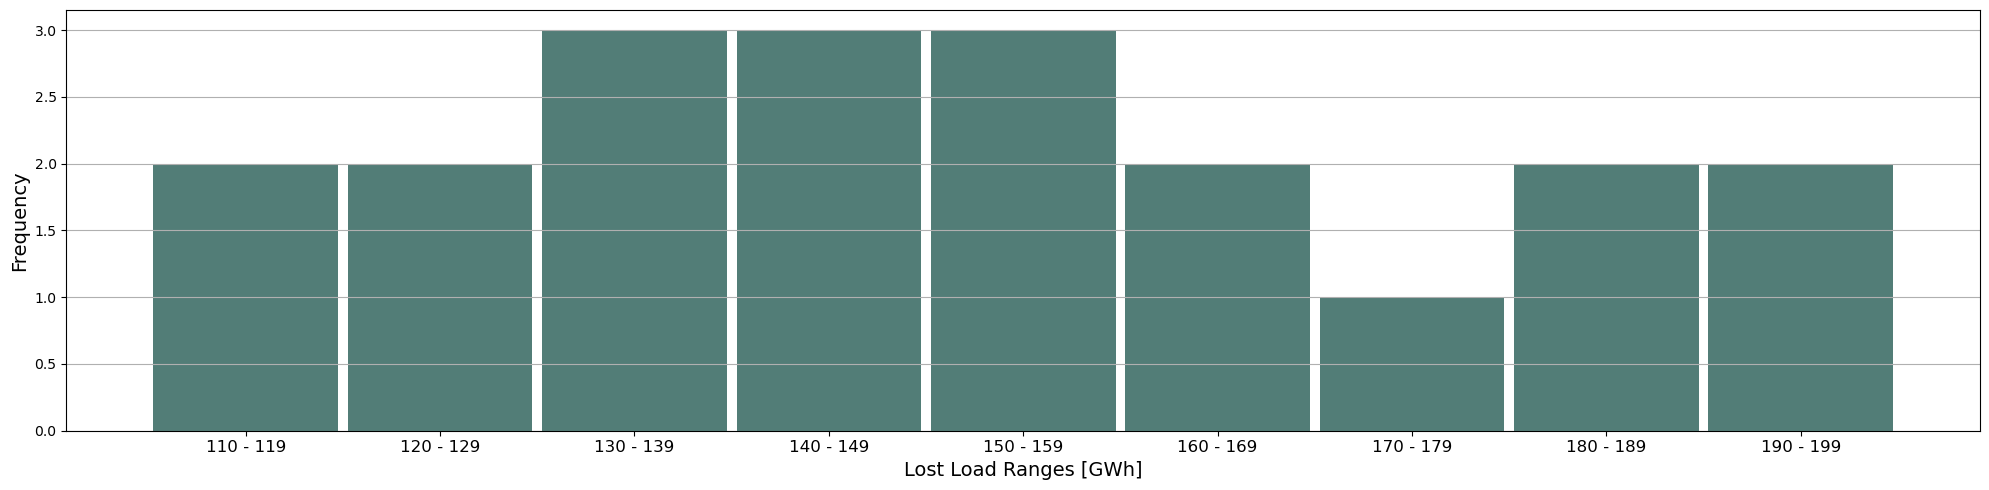

In [10]:
sorted_keys = sorted(all_ranges, key=lambda x: int(x.split(' - ')[0]))

# Extract counts for each sorted range
sorted_counts = [LL_ranges[key] for key in sorted_keys]

# Creating the plot
plt.figure(figsize=(20, 5))
plt.bar(sorted_keys, sorted_counts, color=teal3, width=0.95)
plt.xlabel('Lost Load Ranges [GWh]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
#plt.ylim(0,20)
plt.grid(axis='y')
#plt.title('Distribution of Loss Load Values by Range')
plt.xticks(rotation=0, fontsize=12)  # Rotate the range labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.savefig('../figures/frequency.png')
# Show the plot
plt.show()


<Figure size 1000x500 with 0 Axes>

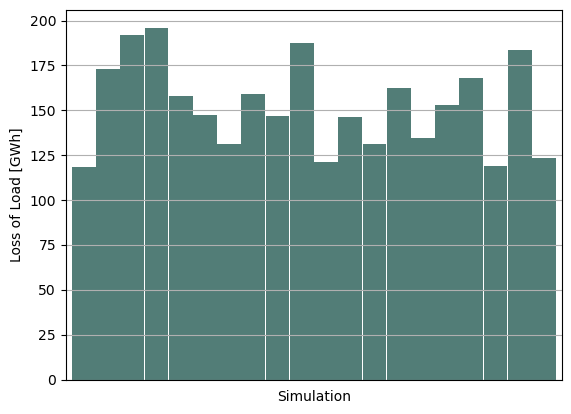

In [11]:
LL_df_sorted = LL_df.sort_values(by=LL_df.columns[0], ascending=False)
plt.figure(figsize=(10,5))
ax = LL_df.plot(kind='bar', color=teal3, width=0.98, legend=False)
plt.xlabel('Simulation')
# current_xticks = ax.get_xticks()
# new_labels = [str(i+1) for i in range(n_simulations)]
# plt.xticks(current_xticks,new_labels,rotation=0)
plt.xticks([])
plt.ylabel('Loss of Load [GWh]')
plt.grid(axis='y')
plt.show()

In [19]:
total_ll_node = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/analysis_scripts/total_nodal_LL.csv')
#times_ll_node = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/analysis_scripts/times_nodal_LL.csv')
EENS_nodal = pd.DataFrame(0, index=total_ll_node['Generator'], columns=['EENS'])
VOLL_nodal = pd.DataFrame(0, index=total_ll_node['Generator'], columns=['VOLL'])
LOLP_nodal = pd.DataFrame(0, index=total_ll_node['Generator'], columns=['LOLP'])
for i, load in enumerate(total_ll_node['Generator']):
    EENS_nodal.loc[load, 'EENS'] = total_ll_node['Total Load Loss'].iloc[i] / (n_simulations*1e3)
    VOLL_nodal.loc[load, 'VOLL'] = (total_ll_node['Total Load Loss'].iloc[i] * price_LL) / (n_simulations*1e9)

EENS_nodal_sorted = EENS_nodal.sort_values(by=EENS_nodal.columns[0], ascending=False)
VOLL_nodal_sorted = VOLL_nodal.sort_values(by=VOLL_nodal.columns[0], ascending=False)

#for i, load in enumerate(times_ll_node['Generator']):
#    LOLP_nodal.loc[load, 'LOLP'] = times_ll_node['Times Load Loss'].iloc[i] / (8760 * n_simulations)

LOLP_nodal_sorted = LOLP_nodal.sort_values(by=LOLP_nodal.columns[0], ascending=False)

In [20]:
avg_component_caused_ll_df = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/analysis_scripts/avg_component_caused_ll.csv')
avg_component_caused_ll_df = avg_component_caused_ll_df.sort_values(by=avg_component_caused_ll_df.columns[1], ascending=False)

for i in range(1,21):
    print('Component: ', avg_component_caused_ll_df['Component'].iloc[i-1], 'Average Lost Load: ', avg_component_caused_ll_df['Average Lost Load'].iloc[i-1])

print(avg_component_caused_ll_df['Average Lost Load'].sum())

Component:  -753810532_0 Average Lost Load:  1.5090301729325064
Component:  -1389783646_0 Average Lost Load:  1.1163284812333605
Component:  -1578860216_0 Average Lost Load:  1.0953423659729986
Component:  2009226556_0 Average Lost Load:  1.0069269991227736
Component:  1342391373_0 Average Lost Load:  0.9939649814917364
Component:  -964455789_0 Average Lost Load:  0.9176613270523314
Component:  837974539_0 Average Lost Load:  0.7950918407399394
Component:  -1516111715_0 Average Lost Load:  0.670332991176882
Component:  C73.0 Average Lost Load:  0.5760900268431439
Component:  -450422875_0 Average Lost Load:  0.5488273020878117
Component:  1007144354_0 Average Lost Load:  0.4731785445238599
Component:  C98.0 Average Lost Load:  0.4727231978244701
Component:  1244424213_0 Average Lost Load:  0.4615112731040171
Component:  -1282014296_0 Average Lost Load:  0.4398722774514746
Component:  20 hydro Average Lost Load:  0.4193696435545206
Component:  1686888444_0 Average Lost Load:  0.410106575

In [24]:
avg_multiple_components_caused_ll_df = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/analysis_scripts/avg_multiple_components_caused_ll.csv')
component_counter = Counter()

# Iterate through the DataFrame and update the counter
for _, row in avg_multiple_components_caused_ll_df.iterrows():
    components = eval(row['Components'])
    avg_lost_load = row['Average Lost Load']
    for component in components:
        component_counter[component] += avg_lost_load

# Get the ten components with the highest lost load
top_ten_components = component_counter.most_common(10)

# Convert to DataFrame for better visualization
top_ten_components_df = pd.DataFrame(top_ten_components, columns=['Component', 'Total Lost Load'])

# Save to CSV
top_ten_components_df.to_csv('top_ten_components.csv', index=False)

top_ten_components_df

print(avg_multiple_components_caused_ll_df['Average Lost Load'].sum())
print(avg_multiple_components_caused_ll_df['Average Lost Load'].sum() + avg_component_caused_ll_df['Average Lost Load'].sum())

122.83050943058315
152.62945644721887
